In [6]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_augmented_example
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP
from src.helping import find_pig_indices
import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

## Load training and validation data

![](images/hist_pig_samples_aug_v2.png)

The model is tuned using the augmented prepared data (hatched orange/blue) and the prepared original data (blue) and is validated using the validation data (green).

In [12]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]
print(pigs)

load_path = "/data/PulHypStudie_Check_npz_v5_SNR20/"

['P_01_PulHyp', 'P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp', 'P_05_PulHyp', 'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp', 'P_09_PulHyp', 'P_10_PulHyp']


In [3]:
X_train, y_train, clrs_pig_train = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards", shuffle=True
)

Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_01_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_01_PulHyp/sample_014999.npz from pig P_01_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_02_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_02_PulHyp/sample_014999.npz from pig P_02_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_03_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_03_PulHyp/sample_014999.npz from pig P_03_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_04_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_04_PulHyp/sample_014999.npz from pig P_04_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_05_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_05_PulHyp/sample_014999.npz from pig P_05_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_06_PulHyp/sample_000500.npz to /dat

In [4]:
X_valid, y_valid, clrs_pig_valid = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards", shuffle=True
)

Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_01_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_01_PulHyp/sample_000499.npz from pig P_01_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_02_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_02_PulHyp/sample_000499.npz from pig P_02_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_03_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_03_PulHyp/sample_000499.npz from pig P_03_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_04_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_04_PulHyp/sample_000499.npz from pig P_04_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_05_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_05_PulHyp/sample_000499.npz from pig P_05_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v5_SNR20/P_06_PulHyp/sample_000000.npz to /data/PulHypStud

In [5]:
for P in range(1, 11):
    find_pig_indices(clrs_pig_train, "Pig_{0:02d}".format(P))
    find_pig_indices(clrs_pig_valid, "Pig_{0:02d}".format(P))

Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.
Found 14500 entries.
Found 500 entries.


In [6]:
print(
    X_train.shape,
    X_valid.shape,
    y_train.shape,
    y_valid.shape,
    clrs_pig_train.shape,
    clrs_pig_valid.shape,
)

(145000, 64, 1024, 1) (5000, 64, 1024, 1) (145000, 3) (5000, 3) (145000, 3) (5000, 3)


**Nomalize data**

In [7]:
np.max(y_train, axis=0), np.max(y_valid, axis=0)

(array([119.11916351, 179.41304016, 146.35994611]),
 array([ 97.0679903 , 144.69028186, 122.57101606]))

In [8]:
dap_factor = 120
sap_factor = 180
map_factor = 150

y_train[:, 0] = y_train[:, 0] / dap_factor  # dap normalization
y_train[:, 1] = y_train[:, 1] / sap_factor  # sap normalization
y_train[:, 2] = y_train[:, 2] / map_factor  # map normalization

y_valid[:, 0] = y_valid[:, 0] / dap_factor  # dap normalization
y_valid[:, 1] = y_valid[:, 1] / sap_factor  # sap normalization
y_valid[:, 2] = y_valid[:, 2] / map_factor  # map normalization

In [9]:
np.max(y_train, axis=0), np.max(y_valid, axis=0)

(array([0.9926597 , 0.99673911, 0.97573297]),
 array([0.80889992, 0.8038349 , 0.81714011]))

**PCA**

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

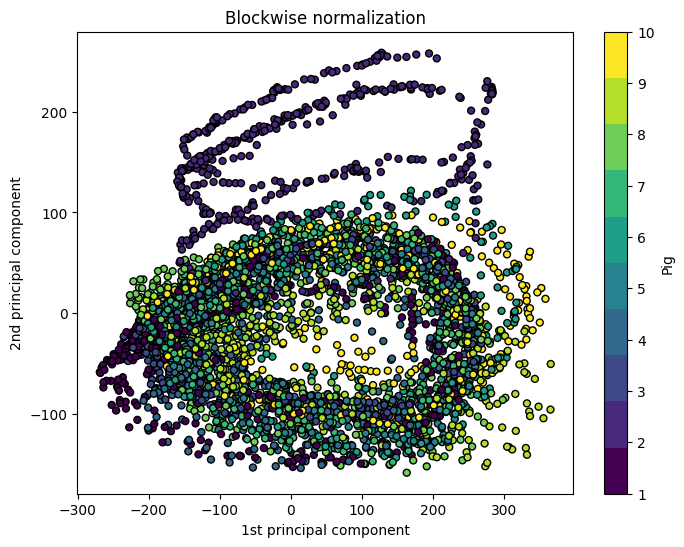

In [11]:
pigs_int = [int(c[0][4:6]) for c in clrs_pig_valid]

cmap = plt.get_cmap("viridis", np.max(pigs_int) - np.min(pigs_int) + 1)

plt.figure(figsize=(8, 6))
plt.title("Blockwise normalization")
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=pigs_int, cmap=cmap, edgecolor="k", s=25
)

c_bar = plt.colorbar(scatter, ticks=np.arange(np.min(pigs_int), np.max(pigs_int) + 1))
c_bar.set_label("Pig")
c_bar.set_ticks(np.arange(np.min(pigs_int), np.max(pigs_int) + 1))

plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

## Hyperparameter Tuning 

- [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [1]:
import keras_tuner as kt
from tensorflow import keras

2025-01-24 10:13:47.460473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 10:13:48.064674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def build_model(hp):
    output_dim = 3

    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))

    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 3, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=14, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice(
            "activation_" + str(i), values=["relu", "elu", "tanh"]
        )
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)

        # create layer
        model.add(
            keras.layers.Conv2D(
                hp_units,
                hp_kernel,
                strides=(hp_strides_0, hp_strides_1),
                padding="same",
            )
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())

    # for i in range(1, hp.Int("num_layers", 1, 4)):
    #    hp_units_dense = hp.Int("units_" + str(i), min_value=2**5, max_value=2**12, step=2**8)
    #    hp_activation_dense = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
    #    model.add(keras.layers.Dense(hp_units_dense, activation=hp_activation_dense))

    # output layer.
    model.add(keras.layers.Dense(output_dim, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanAbsoluteError(),
        # loss=keras.losses.MeanSquaredError(),
        metrics=["accuracy"],
    )
    print(model.summary())

    return model

In [3]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    directory="mapper_tuning_v5",
    project_name="mapper_tuning_20db",
)

2025-01-24 10:13:56.667540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2025-01-24 10:13:56.669601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 856 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0
2025-01-24 10:13:56.671975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79087 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:46:00.0, compute capability: 8.0
2025-01-24 10:13:56.674079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79087 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bus 

Reloading Tuner from mapper_tuning_v5/mapper_tuning_20db/tuner0.json


**Tune model on full data**

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6)
tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=10,
    validation_data=(X_valid, y_valid),
    callbacks=[stop_early],
)

Trial 45 Complete [00h 02m 22s]
val_accuracy: 0.5275999903678894

Best val_accuracy So Far: 0.6344000101089478
Total elapsed time: 02h 04m 51s

Search: Running Trial #46

Value             |Best Value So Far |Hyperparameter
6                 |3                 |num_layers
14                |6                 |units_1
7                 |13                |kernel_1
1                 |2                 |units_0_1
3                 |2                 |units_1_1
elu               |elu               |activation_1
0.9               |0.5               |dropout_1
6                 |2                 |units_2
14                |12                |kernel_2
2                 |1                 |units_0_2
2                 |3                 |units_1_2
relu              |relu              |activation_2
0.4               |0.2               |dropout_2
0.001             |0.001             |learning_rate
10                |2                 |units_3
2                 |9                 |kernel_3
2     

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 342, 14)    │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 342, 14)    │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 342, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 342, 14)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 171, 6)     │        16,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 171, 6)     │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 171, 6)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 171, 6)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 57, 10)     │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 57, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 57, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 57, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 19, 10)      │        16,910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 19, 10)      │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 19, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 19, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 10, 6)       │         2,946 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 10, 6)       │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6, 10, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 10, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,083 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 38,543 (150.56 KB)

 Trainable params: 38,451 (150.20 KB)

 Non-trainable params: 92 (368.00 B)

None


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 3/4
14500/14500 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.6068 - loss: 0.0540 - val_accuracy: 0.5178 - val_loss: 0.0645
Epoch 4/4
 2585/14500 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.6168 - loss: 0.0538

**Train the model with the parameters from the hpt on the first nine pigs**

In [4]:
m_idx = 20

In [ ]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]]  # exclude 10
print(pigs)

# load_path = "/data/PulHypStudie_Check_npz_v5_SNR20/"
X_expt10, y_expt10, clrs_pig_expt10 = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards", shuffle=True
)
X_valid_expt10, y_valid_expt10, clrs_pig_valid_expt10 = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards", shuffle=True
)

In [ ]:
np.max(y_expt10, axis=0), np.max(y_valid_expt10, axis=0)

In [ ]:
dap_factor = 120
sap_factor = 180
map_factor = 150

y_expt10[:, 0] = y_expt10[:, 0] / dap_factor  # dap normalization
y_expt10[:, 1] = y_expt10[:, 1] / sap_factor  # sap normalization
y_expt10[:, 2] = y_expt10[:, 2] / map_factor  # map normalization

y_valid_expt10[:, 0] = y_valid_expt10[:, 0] / dap_factor  # dap normalization
y_valid_expt10[:, 1] = y_valid_expt10[:, 1] / sap_factor  # sap normalization
y_valid_expt10[:, 2] = y_valid_expt10[:, 2] / map_factor  # map normalization

In [ ]:
np.max(y_expt10, axis=0), np.max(y_valid_expt10, axis=0)

In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)

{'num_layers': 4, 'units_1': 10, 'kernel_1': 2, 'units_0_1': 2, 'units_1_1': 2, 'activation_1': 'relu', 'dropout_1': 0.2, 'units_2': 10, 'kernel_2': 12, 'units_0_2': 3, 'units_1_2': 2, 'activation_2': 'relu', 'dropout_2': 0.1, 'learning_rate': 0.01, 'units_3': 10, 'kernel_3': 14, 'units_0_3': 4, 'units_1_3': 4, 'activation_3': 'tanh', 'dropout_3': 0.2, 'units_4': 6, 'kernel_4': 2, 'units_0_4': 3, 'units_1_4': 4, 'activation_4': 'elu', 'dropout_4': 0.1, 'units_5': 14, 'kernel_5': 10, 'units_0_5': 4, 'units_1_5': 2, 'activation_5': 'elu', 'dropout_5': 0.30000000000000004, 'units_6': 14, 'kernel_6': 2, 'units_0_6': 3, 'units_1_6': 3, 'activation_6': 'tanh', 'dropout_6': 0.8, 'tuner/epochs': 50, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 512, 10)    │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 512, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 256, 10)    │        14,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 256, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 64, 10)      │        19,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 64, 10)      │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 64, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 64, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         5,763 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,953 (156.07 KB)

 Trainable params: 39,893 (155.83 KB)

 Non-trainable params: 60 (240.00 B)

None


In [8]:
best_hps.values

{'num_layers': 4,
 'units_1': 10,
 'kernel_1': 2,
 'units_0_1': 2,
 'units_1_1': 2,
 'activation_1': 'relu',
 'dropout_1': 0.2,
 'units_2': 10,
 'kernel_2': 12,
 'units_0_2': 3,
 'units_1_2': 2,
 'activation_2': 'relu',
 'dropout_2': 0.1,
 'learning_rate': 0.01,
 'units_3': 10,
 'kernel_3': 14,
 'units_0_3': 4,
 'units_1_3': 4,
 'activation_3': 'tanh',
 'dropout_3': 0.2,
 'units_4': 6,
 'kernel_4': 2,
 'units_0_4': 3,
 'units_1_4': 4,
 'activation_4': 'elu',
 'dropout_4': 0.1,
 'units_5': 14,
 'kernel_5': 10,
 'units_0_5': 4,
 'units_1_5': 2,
 'activation_5': 'elu',
 'dropout_5': 0.30000000000000004,
 'units_6': 14,
 'kernel_6': 2,
 'units_0_6': 3,
 'units_1_6': 3,
 'activation_6': 'tanh',
 'dropout_6': 0.8,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
history = model.fit(
    X_expt10,
    y_expt10,
    epochs=50,
    batch_size=8,
    validation_data=(X_valid_expt10, y_valid_expt10),
)

In [ ]:
model.save_weights(f"src/weights_v5/mapper_model_{m_idx}.weights.h5")

In [10]:
model.load_weights(f"src/weights_v5/mapper_model_{m_idx}.weights.h5")

**Test model performance with trained model**

In [13]:
pig_test_s_dict = {
    "P_01_PulHyp": 10338,
    "P_02_PulHyp": 12859,
    "P_03_PulHyp": 8124,
    "P_04_PulHyp": 8914,
    "P_05_PulHyp": 10063,
    "P_06_PulHyp": 6934,
    "P_07_PulHyp": 5692,
    "P_08_PulHyp": 7189,
    "P_09_PulHyp": 8228,
    "P_10_PulHyp": 6552,
}

# load pig 10 as the test pig
pigs_test = ["P_10_PulHyp"]
sample_skip = pig_test_s_dict[pigs_test[0]]
print(f"{sample_skip=}")

X_10, y_10, clrs_pig_10 = load_augmented_example(
    load_path,
    pigs_test,
    sample_skip=sample_skip,
    load_samples="downwards",
    shuffle=False,
)

sample_skip=6552
Selected 6552 from /data/PulHypStudie_Check_npz_v5_SNR20/P_10_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_10_PulHyp/sample_006551.npz from pig P_10_PulHyp.


In [16]:
# predict EIT data of pig 10
y_pred = model.predict(X_10)

Y_true = y_10

Y_pred = np.empty(y_pred.shape)
Y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
Y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
Y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [72]:
np.savez(
    f"src/weights_v5/result_mapper_{m_idx}.npz",
    Y_true=Y_true,
    Y_pred=Y_pred,
)

**Error estimation**

In [79]:
import pandas as pd
import seaborn as sns

In [80]:
DAP_err = Y_pred[:, 0] - Y_true[:, 0]
SAP_err = Y_pred[:, 1] - Y_true[:, 1]
MAP_err = Y_pred[:, 2] - Y_true[:, 2]

In [81]:
DF_err = pd.DataFrame({"DAP": DAP_err, "SAP": SAP_err, "MAP": MAP_err})
DF_err.to_csv(f"src/results/mapper_{m_idx}.csv", index=False)

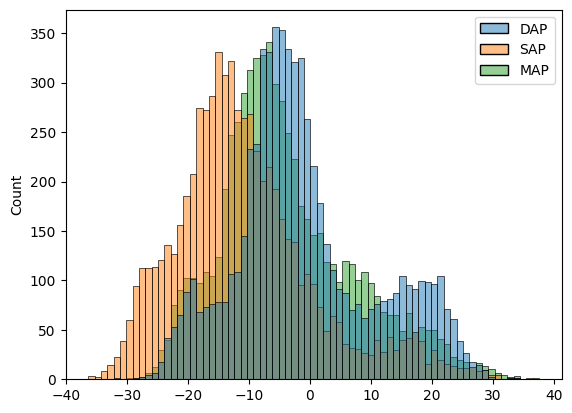

In [82]:
sns.histplot(DF_err)
plt.savefig(f"src/results/histplot_{m_idx}.png")

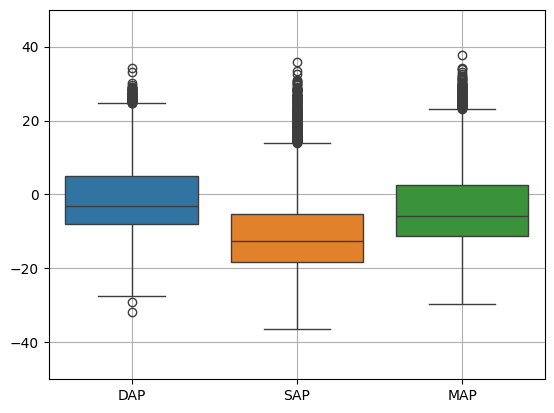

In [83]:
sns.boxplot(DF_err)
plt.grid()
plt.ylim([-50, 50])
plt.savefig(f"src/results/boxplot_{m_idx}.png")

In [84]:
model.loss(Y_true, Y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.99547>

In [85]:
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.grid()
# plt.ylim([0,1.])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig(f"src/results/accrcy_{m_idx}.png")
plt.show()

NameError: name 'history' is not defined

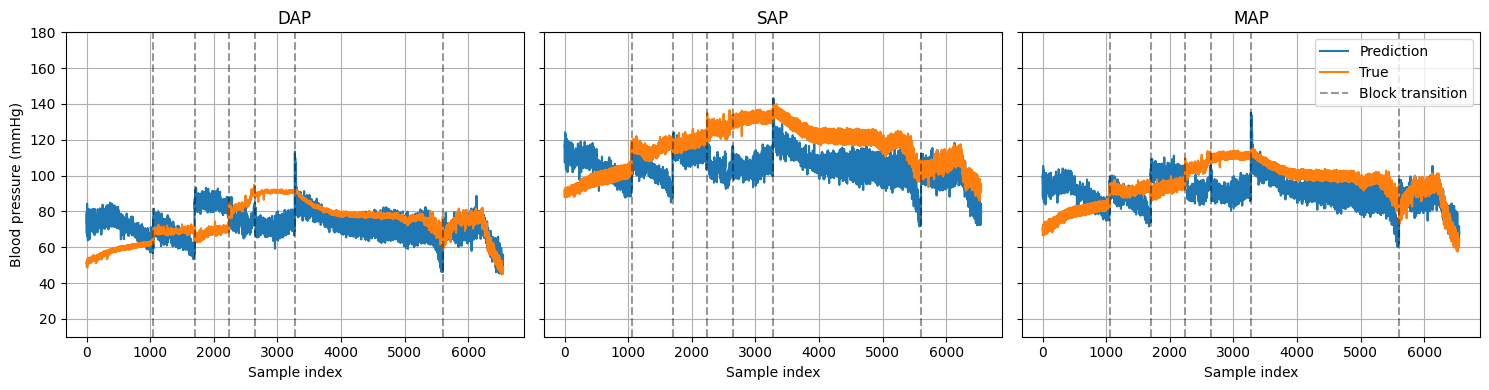

In [86]:
ttl = ["DAP", "SAP", "MAP"]
block_list = [int(bl.split("_")[1]) for bl in clrs_pig_10[:, 1]]
change_indices = np.where(np.diff(block_list) != 0)[0] + 1
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, ax in enumerate(axes):
    ax.set_title(ttl[i])
    ax.plot(Y_pred[:, i], label="Prediction")
    ax.plot(Y_true[:, i], label="True")
    ax.set_ylim([10, 180])
    for idx, vline in enumerate(change_indices):
        if idx == 0:
            ax.axvline(
                vline,
                color="black",
                linestyle="--",
                alpha=0.4,
                label="Block transition",
            )
        else:
            ax.axvline(vline, color="black", linestyle="--", alpha=0.4)
    ax.grid()
    ax.set_xlabel("Sample index")
    if i == 0:
        ax.set_ylabel("Blood pressure (mmHg)")

plt.legend()
plt.tight_layout()
# plt.savefig(f"dap_sap_map_test_pig_0{PIG}.png", dpi=900)
plt.show()

In [87]:
from scipy.signal import butter, filtfilt


def lowpass_filter(data, cutoff=10, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

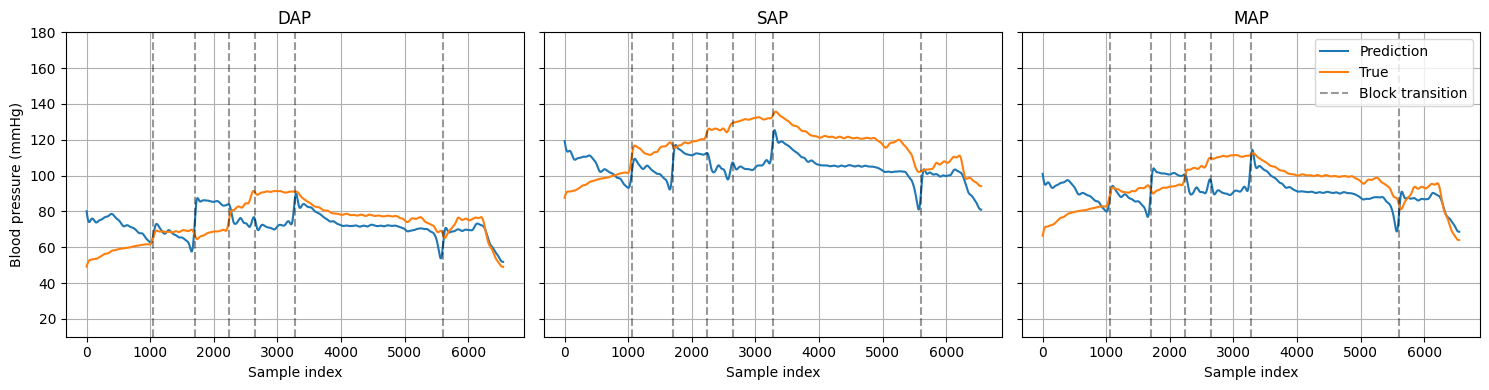

In [88]:
ttl = ["DAP", "SAP", "MAP"]
block_list = [int(bl.split("_")[1]) for bl in clrs_pig_10[:, 1]]
change_indices = np.where(np.diff(block_list) != 0)[0] + 1
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, ax in enumerate(axes):
    ax.set_title(ttl[i])
    ax.plot(lowpass_filter(Y_pred[:, i]), label="Prediction")
    ax.plot(lowpass_filter(Y_true[:, i]), label="True")
    ax.set_ylim([10, 180])
    for idx, vline in enumerate(change_indices):
        if idx == 0:
            ax.axvline(
                vline,
                color="black",
                linestyle="--",
                alpha=0.4,
                label="Block transition",
            )
        else:
            ax.axvline(vline, color="black", linestyle="--", alpha=0.4)
    ax.grid()
    ax.set_xlabel("Sample index")
    if i == 0:
        ax.set_ylabel("Blood pressure (mmHg)")

plt.legend()
plt.tight_layout()
# plt.savefig(f"dap_sap_map_test_pig_0{PIG}.png", dpi=900)
plt.show()

**Rages in between $\pm10$mmHg**

In [98]:
DAP_err = Y_pred[:, 0] - Y_true[:, 0] - np.mean(Y_pred[:, 0] - Y_true[:, 0]) + 4
SAP_err = Y_pred[:, 1] - Y_true[:, 1] - np.mean(Y_pred[:, 1] - Y_true[:, 1]) + 4
MAP_err = Y_pred[:, 2] - Y_true[:, 2] - np.mean(Y_pred[:, 2] - Y_true[:, 2]) + 4

In [99]:
DF_err = pd.DataFrame({"DAP": DAP_err, "SAP": SAP_err, "MAP": MAP_err})

In [100]:
DF_err

,DAP,SAP,MAP
0,35.180177,45.778880,41.725340
1,30.650727,42.757297,36.464932
2,32.604814,43.509052,37.954152
3,20.649808,29.690921,24.200127
4,33.151376,43.217494,38.726379
...,...,...,...
6547,10.750832,2.625564,13.658748
6548,6.405431,-1.883920,9.866361
6549,11.307820,1.252936,13.491274
6550,9.228612,-0.737001,11.102242


In [114]:
print(
    DF_err["SAP"][(DF_err["SAP"] >= -10) & (DF_err["SAP"] <= 10)].shape[0] / 6552 * 100
)
print(
    DF_err["MAP"][(DF_err["MAP"] >= -10) & (DF_err["MAP"] <= 10)].shape[0] / 6552 * 100
)
print(
    DF_err["DAP"][(DF_err["DAP"] >= -10) & (DF_err["DAP"] <= 10)].shape[0] / 6552 * 100
)

67.3992673992674
66.11721611721612
65.06410256410257


<Axes: title={'center': 'Histogram for manually compensated offset'}, ylabel='Count'>

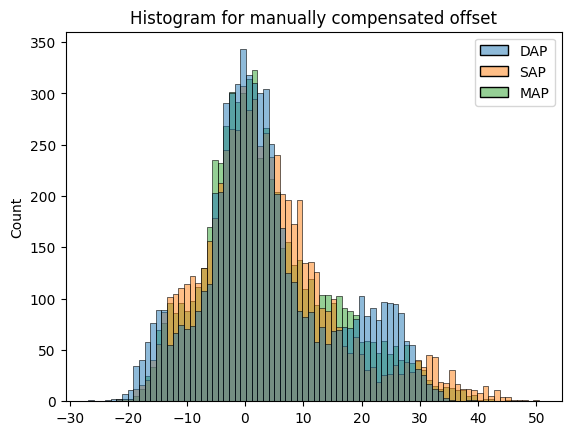

In [102]:
plt.title("Histogram for manually compensated offset")
sns.histplot(DF_err)

In [ ]:
def calculate_percentage_in_range(df, AP, lower_bound, upper_bound):
    total_count = df[f"{AP}cnt"].sum()
    filtered_df = df[(df[f"{AP}xs"] >= lower_bound) & (df[f"{AP}xs"] <= upper_bound)]
    print(filtered_df)
    range_count = filtered_df[f"{AP}cnt"].sum()
    percentage = (range_count / total_count) * 100
    return percentage

___

## Export

**export results**

In [131]:
from plotLaTeX import HistPlot, BoxPlot

In [132]:
hist = HistPlot(bins=25)

In [133]:
hist.add_histdata(SAP_err, "SAP")
hist.add_histdata(MAP_err, "MAP")
hist.add_histdata(DAP_err, "DAP")

Current data stack:
       SAPxs  SAPcnt
0 -34.947544      11
1 -32.062229      57
2 -29.176915     212
3 -26.291600     307
4 -23.406285     366
Current data stack:
       SAPxs  SAPcnt      MAPxs  MAPcnt
0 -34.947544      11 -28.250923       5
1 -32.062229      57 -25.562402      37
2 -29.176915     212 -22.873881     142
3 -26.291600     307 -20.185359     257
4 -23.406285     366 -17.496838     259
Current data stack:
       SAPxs  SAPcnt      MAPxs  MAPcnt      DAPxs  DAPcnt
0 -34.947544      11 -28.250923       5 -30.572020       1
1 -32.062229      57 -25.562402      37 -27.928775       4
2 -29.176915     212 -22.873881     142 -25.285530      24
3 -26.291600     307 -20.185359     257 -22.642285     122
4 -23.406285     366 -17.496838     259 -19.999040     229


In [134]:
hist.add_axis_labels(xlabel="Absolute AP deviation (mmHg)", ylabel="Count")

In [135]:
hist.export(f_name="hist_results.csv")

**Export**

Current data stack:
       SAPxs  SAPcnt      MAPxs  MAPcnt      DAPxs  DAPcnt
0 -34.947544      11 -28.250923       5 -30.572020       1
1 -32.062229      57 -25.562402      37 -27.928775       4
2 -29.176915     212 -22.873881     142 -25.285530      24
3 -26.291600     307 -20.185359     257 -22.642285     122
4 -23.406285     366 -17.496838     259 -19.999040     229

***********
LaTeX code:
***********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel=Count,
            xlabel=Absolute AP deviation (mmHg),
            % xtick={0,1,...,10},
            % bar width=7pt,
            width=7.5cm,
            height=3cm,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
            legend columns = 3,
            legend style={at={(0,1.05)}, legend cell align=left, align=left, draw=white!15!black, mar

In [116]:
box = BoxPlot()

In [117]:
box.add_data(SAP_err, "SAP")
box.add_data(MAP_err, "MAP")
box.add_data(DAP_err, "DAP")

SAP
{'median': -12.522838941751054, 'lower_quartile': -18.14733605616578, 'upper_quartile': -5.299989395085362, 'lower_whisker': -36.390201450265636, 'upper_whisker': 13.960669194594772}
SAP
{'median': -12.522838941751054, 'lower_quartile': -18.14733605616578, 'upper_quartile': -5.299989395085362, 'lower_whisker': -36.390201450265636, 'upper_whisker': 13.960669194594772}
MAP
{'median': -5.928894576835788, 'lower_quartile': -11.185748124994557, 'upper_quartile': 2.5850254216553346, 'lower_whisker': -29.595183751931188, 'upper_whisker': 23.2344903651082}
SAP
{'median': -12.522838941751054, 'lower_quartile': -18.14733605616578, 'upper_quartile': -5.299989395085362, 'lower_whisker': -36.390201450265636, 'upper_whisker': 13.960669194594772}
MAP
{'median': -5.928894576835788, 'lower_quartile': -11.185748124994557, 'upper_quartile': 2.5850254216553346, 'lower_whisker': -29.595183751931188, 'upper_whisker': 23.2344903651082}
DAP
{'median': -3.0833908843431743, 'lower_quartile': -8.074914028577

In [118]:
box.add_axis_labels(xlabel="AP", ylabel="Absolute Error (mmHg)")

In [119]:
box.LaTeXcode()

	Don´t forget to import the packages:

\usepackage{graphicx}
\usepackage{tikz,pgfplots}
\usepgfplotslibrary{statistics}

*	*********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel=Absolute Error (mmHg),
            xlabel=AP,
            xtick={ 1, 2, 3 },
            xticklabels={ SAP, MAP, DAP },
            width=7.5cm,
            height=3cm,
            boxplot/draw direction = y,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
]
            \addplot[
            fill,
            fill opacity=0.7,
            boxplot prepared={
                median=-12.522838941751054,
                upper quartile=-5.299989395085362,
                lower quartile=-18.14733605616578,
                upper whisker=13.960669194594772,
                lower whisker=-36.390201450265636
                            },
  

In [122]:
DAP_rerr = (Y_pred[:, 0] - Y_true[:, 0]) / Y_true[:, 0] * 100
SAP_rerr = (Y_pred[:, 1] - Y_true[:, 1]) / Y_true[:, 1] * 100
MAP_rerr = (Y_pred[:, 2] - Y_true[:, 2]) / Y_true[:, 2] * 100

In [127]:
box_r = BoxPlot()

In [128]:
box_r.add_data(SAP_rerr, "SAP")
box_r.add_data(MAP_rerr, "MAP")
box_r.add_data(DAP_rerr, "DAP")

SAP
{'median': -10.502229698453629, 'lower_quartile': -15.142819871360572, 'upper_quartile': -4.841132896342934, 'lower_whisker': -28.24035205713551, 'upper_whisker': 10.565094596959728}
SAP
{'median': -10.502229698453629, 'lower_quartile': -15.142819871360572, 'upper_quartile': -4.841132896342934, 'lower_whisker': -28.24035205713551, 'upper_whisker': 10.565094596959728}
MAP
{'median': -6.03982048321406, 'lower_quartile': -11.27504304428077, 'upper_quartile': 2.9553576917333304, 'lower_whisker': -30.337584437090875, 'upper_whisker': 24.294760920180927}
SAP
{'median': -10.502229698453629, 'lower_quartile': -15.142819871360572, 'upper_quartile': -4.841132896342934, 'lower_whisker': -28.24035205713551, 'upper_whisker': 10.565094596959728}
MAP
{'median': -6.03982048321406, 'lower_quartile': -11.27504304428077, 'upper_quartile': 2.9553576917333304, 'lower_whisker': -30.337584437090875, 'upper_whisker': 24.294760920180927}
DAP
{'median': -4.090648570675149, 'lower_quartile': -10.561684571315

In [129]:
box_r.add_axis_labels(xlabel="AP", ylabel="Relative Error")

In [130]:
box_r.LaTeXcode()

	Don´t forget to import the packages:

\usepackage{graphicx}
\usepackage{tikz,pgfplots}
\usepgfplotslibrary{statistics}

*	*********

\begin{figure}[h]
    \centering
    \tikzstyle{every node}=[font=\footnotesize]
    \begin{tikzpicture}
        \begin{axis}[
            ylabel=Relative Error,
            xlabel=AP,
            xtick={ 1, 2, 3 },
            xticklabels={ SAP, MAP, DAP },
            width=7.5cm,
            height=3cm,
            boxplot/draw direction = y,
            at={(0cm,0cm)},
            scale only axis,
            axis background/.style={fill=white},
            grid=both,
]
            \addplot[
            fill,
            fill opacity=0.7,
            boxplot prepared={
                median=-10.502229698453629,
                upper quartile=-4.841132896342934,
                lower quartile=-15.142819871360572,
                upper whisker=10.565094596959728,
                lower whisker=-28.24035205713551
                            },
        ]

In [97]:
DF_rerr = pd.DataFrame({"DAP": DAP_rerr, "SAP": SAP_rerr, "MAP": MAP_rerr})

(-50.0, 50.0)

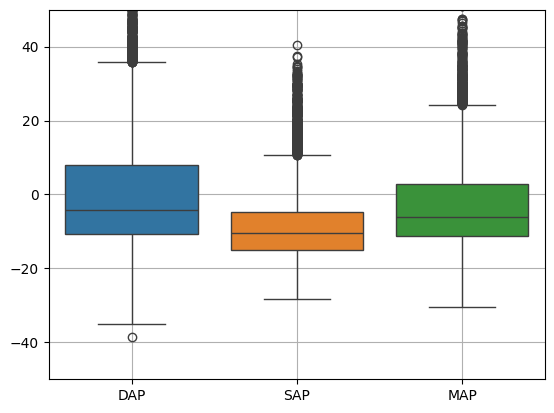

In [98]:
sns.boxplot(DF_rerr)
plt.grid()
plt.ylim([-50, 50])

In [99]:
df = DF_rerr

summary = {}
for column in df.columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    median = df[column].median()
    iqr = q3 - q1  # Interquartilsabstand
    lower_whisker = df[column][df[column] >= (q1 - 1.5 * iqr)].min()
    upper_whisker = df[column][df[column] <= (q3 + 1.5 * iqr)].max()

    summary[column] = {
        "Q1": q1,
        "Median": median,
        "Q3": q3,
        "Lower Whisker": lower_whisker,
        "Upper Whisker": upper_whisker,
    }

summary_df = pd.DataFrame(summary).T
print(summary_df)

            Q1     Median        Q3  Lower Whisker  Upper Whisker
DAP -10.561685  -4.090649  7.986557     -35.026573      35.807151
SAP -15.142820 -10.502230 -4.841133     -28.240352      10.565095
MAP -11.275043  -6.039820  2.955358     -30.337584      24.294761
